In [1]:
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
import re
import pickle

from IPython.display import display
from collections import Counter
from functools import partial

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
from pprint import pprint

In [2]:
from sklearn.model_selection import RandomizedSearchCV, StratifiedKFold, KFold
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from lightgbm import LGBMClassifier, LGBMRegressor

### reading data

In [3]:
from google.colab import drive
drive.mount('/content/gdrive/')

path_to_files = '/content/gdrive/My Drive/_made/auctions/'

Mounted at /content/gdrive/


### CPM calculation

In [4]:
#calculating CPM
#calculating the value that the Advertisers Bid for the month of June
# CPM(the value which was the winning bid value) = 
#((revenue of the publisher*100)/revenue_share_percentage)/measurable_impressions)*1000

def weird_division(n, d):
    return n / d if d else 0

# all_data['CPM'] = all_data.apply(lambda x: weird_division( x['total_revenue'] * 100 , x['measurable_impressions']) * 1000 , axis = 1)

### winsorization + train-test time split

В качестве train необходимо использовать данные до 21.06.2019 включительно, для test - все оставшиеся (важно: из test исключаются отрицательные значения, а также обрезаются значения справа по 95 перцентилю)

- не совсем однозначное условие, предполагаем, что квантиль берётся после исключения отрицательных значений и только по распределению на test-выборке

In [5]:
all_data = pd.read_csv(path_to_files + 'dataset.csv')
all_data['CPM'] = all_data.apply(lambda x: weird_division( x['total_revenue'] * 100 , x['measurable_impressions']) * 1000 , axis = 1)
(all_data['CPM'] < 0).sum(), (all_data['CPM'] == 0).sum(), (all_data['CPM'] > 0).sum()

(1, 296673, 270617)

#### вроде бы такой вариант сплита и винзоризации самый адекватный

In [6]:
all_data = pd.read_csv(path_to_files + 'dataset.csv')
all_data['CPM'] = all_data.apply(lambda x: weird_division( x['total_revenue'] * 100 , x['measurable_impressions']) * 1000 , axis = 1)
all_data = all_data.query("CPM >= 0")
train_data = all_data.query("date < '2019-06-22'")
test_data = all_data.query("date >= '2019-06-22'")

In [7]:
 f"{np.quantile(all_data['CPM'], q = 0.95):.4f} {np.quantile(train_data['CPM'], q = 0.95):.4f} {np.quantile(test_data['CPM'], q = 0.95):.4f}"

'526.9231 520.0000 536.1765'

In [8]:
np.quantile(all_data['CPM'], q = np.arange(0,1.01,0.01))[90:]

array([2.70000000e+02, 3.01434882e+02, 3.50000000e+02, 4.00000000e+02,
       4.62811769e+02, 5.26923077e+02, 5.92000000e+02, 8.10000000e+02,
       1.00000000e+03, 1.43000000e+03, 2.83620000e+05])

In [9]:
train_data = train_data[train_data['CPM'] < np.quantile(test_data['CPM'], q = 0.95)].reset_index(drop = True)
test_data = test_data[test_data['CPM'] < np.quantile(test_data['CPM'], q = 0.95)].reset_index(drop = True)

### target distribution

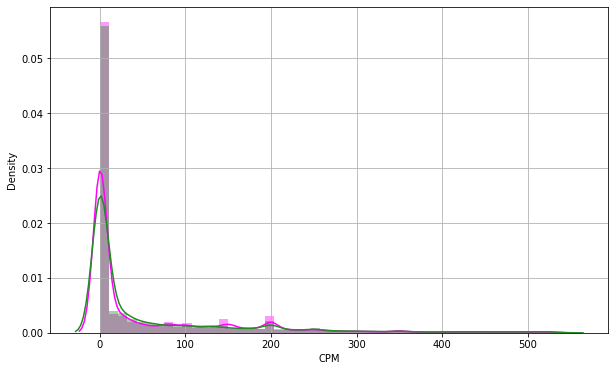

In [10]:
plt.figure(figsize = (10,6))

sns.distplot(train_data['CPM'], color = 'magenta')
sns.distplot(test_data['CPM'], color = 'forestgreen')
plt.grid(True)

#### логнормальненько так, хотя даже и не так (см. ниже) - что-то zero-inflated, но непрерывно, а не Poisson

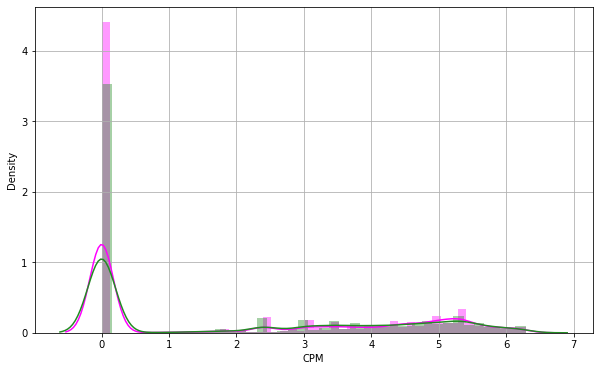

In [11]:
EPS = 1

plt.figure(figsize = (10,6))

sns.distplot(np.log(train_data['CPM'] + EPS), color = 'magenta')
sns.distplot(np.log(test_data['CPM'] + EPS), color = 'forestgreen')
plt.grid(True)

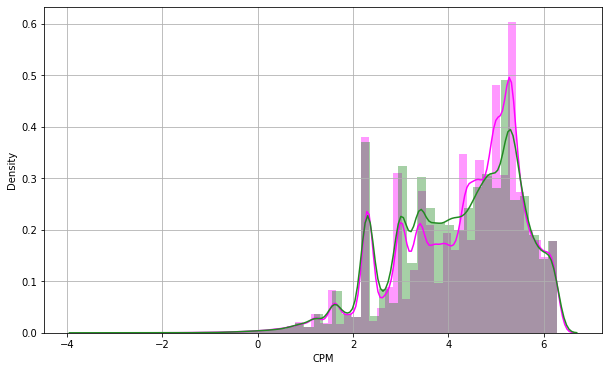

In [12]:
EPS = 1

plt.figure(figsize = (10,6))

sns.distplot(np.log(train_data['CPM'][train_data['CPM'] > 0]), color = 'magenta')
sns.distplot(np.log(test_data['CPM'][test_data['CPM'] > 0]), color = 'forestgreen')
plt.grid(True)

### features distribution

In [13]:
drops = ['CPM', 'date', 'total_revenue', 'integration_type_id', 'revenue_share_percent']
features = [f for f in train_data.columns if f not in drops]

cat_features = [f for f in features if f.endswith('_id')]
num_features = [f for f in features if f not in cat_features]

### определим неконстистентные с обучающей фичи на тестовой выборке

In [15]:
from tqdm.notebook import tqdm
cat_unions = {}
for f in tqdm(cat_features):
    train_gb = train_data.groupby(f)[['CPM']].agg(['mean', 'count'])
    test_gb = test_data.groupby(f)[['CPM']].agg(['mean', 'count'])
    inconsistent_categories = pd.merge(train_gb, test_gb, left_index = True, right_index = True, how = 'outer')
    if inconsistent_categories.isna().sum(axis = 0).sum() > 0:
        cat_unions[f] = set(inconsistent_categories.index[inconsistent_categories.isna().sum(axis = 1) > 0])
        print(f'{len(train_data[train_data[f].isin(cat_unions[f])])} rows in train have categories in {f} which are not in the test')

567 rows in train have categories in geo_id which are not in the test
4327 rows in train have categories in advertiser_id which are not in the test
4331 rows in train have categories in order_id which are not in the test
0 rows in train have categories in line_item_type_id which are not in the test
4327 rows in train have categories in monetization_channel_id which are not in the test
4344 rows in train have categories in ad_unit_id which are not in the test



In [16]:
for f in tqdm(cat_features):
    drop_criteria = cat_unions.get(f, None)
    if drop_criteria:
        print(f' dropping {len(train_data[train_data[f].isin(drop_criteria)])} rows from train cause of {f}')
        train_data = train_data[~train_data[f].isin(drop_criteria)]
        print(f'{len(train_data)} rows left')

 dropping 567 rows from train cause of geo_id
377038 rows left
 dropping 4289 rows from train cause of advertiser_id
372749 rows left
 dropping 4 rows from train cause of order_id
372745 rows left
 dropping 0 rows from train cause of line_item_type_id
372745 rows left
 dropping 0 rows from train cause of monetization_channel_id
372745 rows left
 dropping 17 rows from train cause of ad_unit_id
372728 rows left



### feature exploration

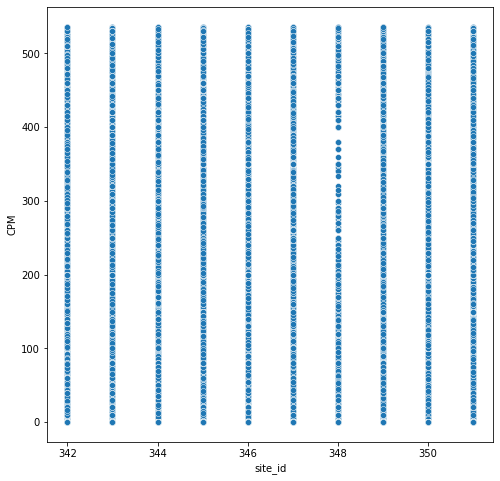

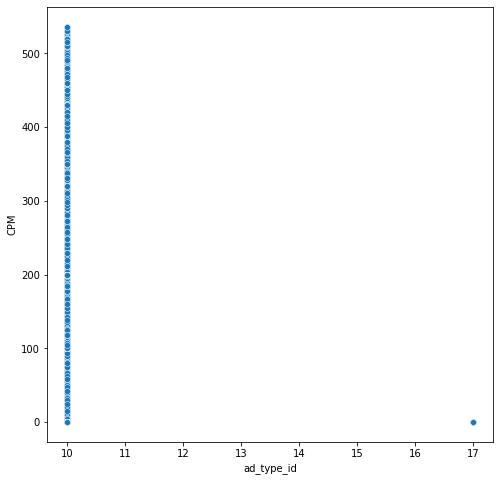

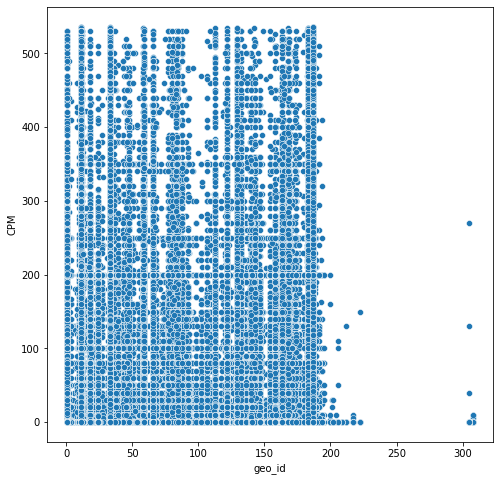

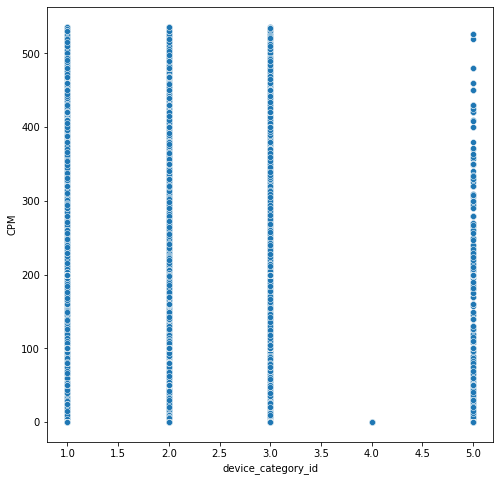

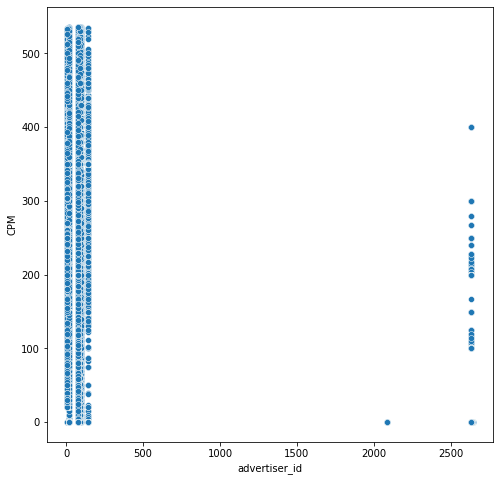

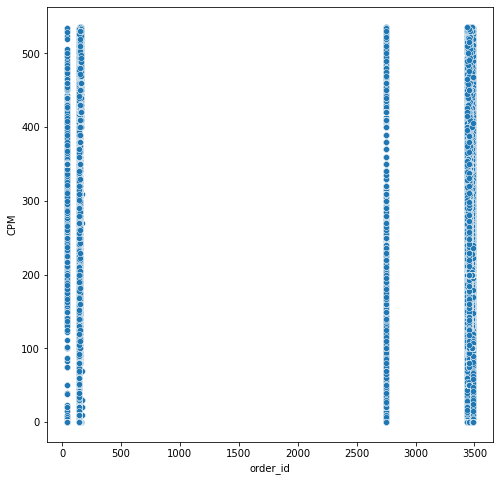

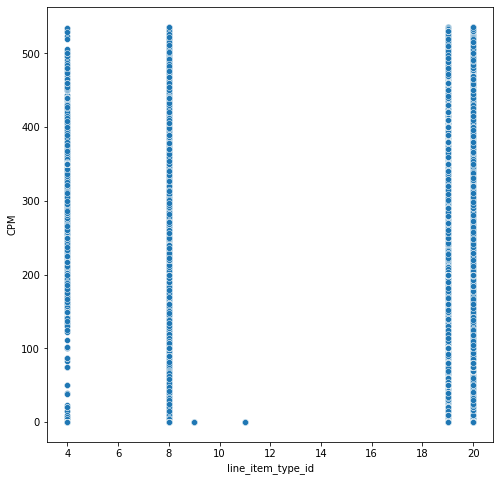

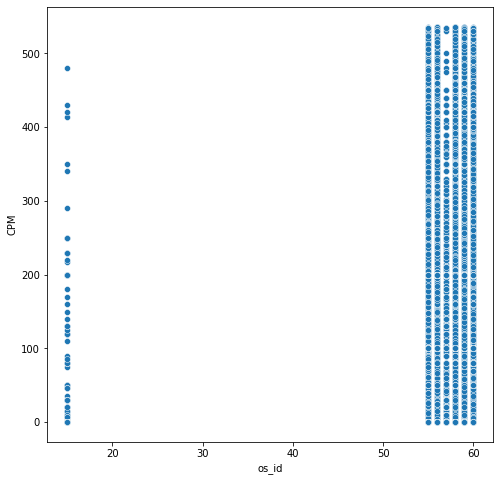

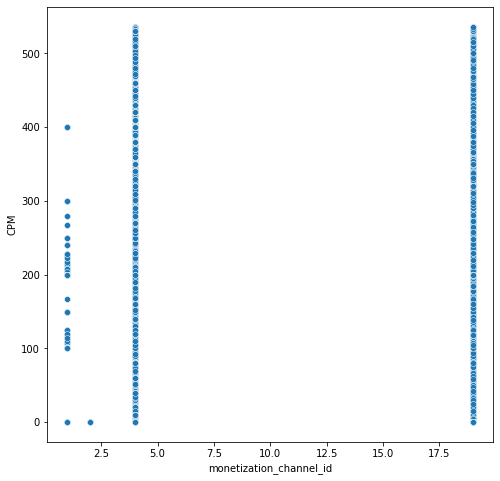

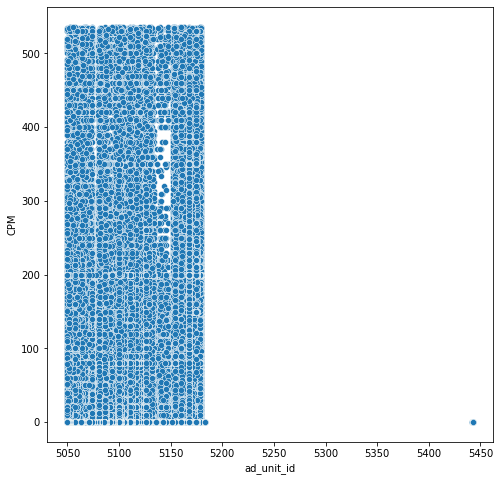

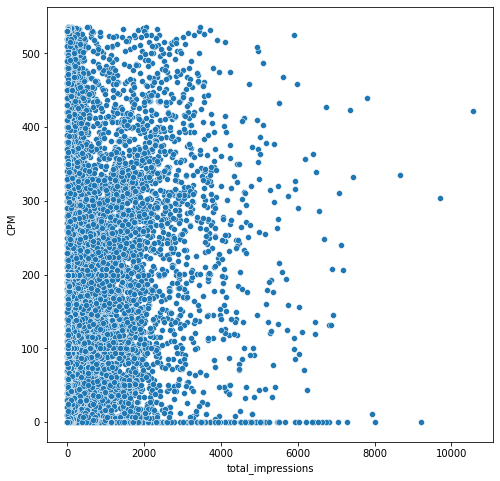

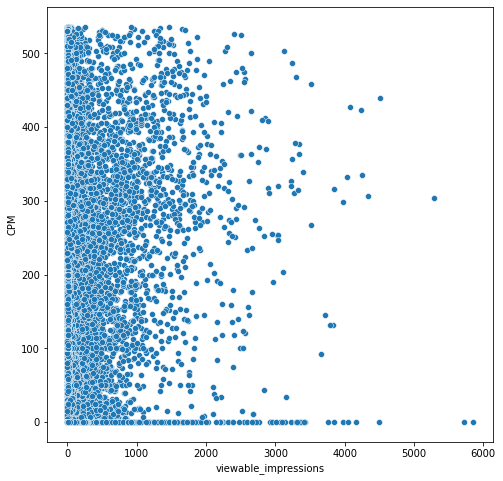

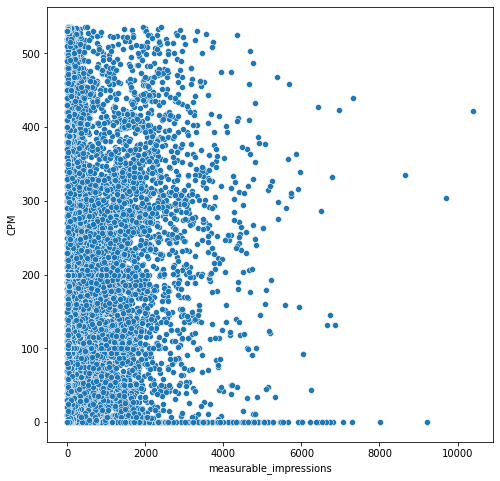

In [17]:
for f in tqdm(features):
    plt.figure(figsize = (8,8))
    _ = sns.scatterplot(data = train_data, y = 'CPM', x = f)

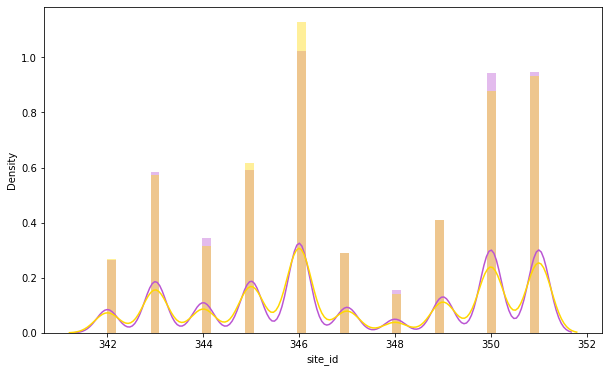

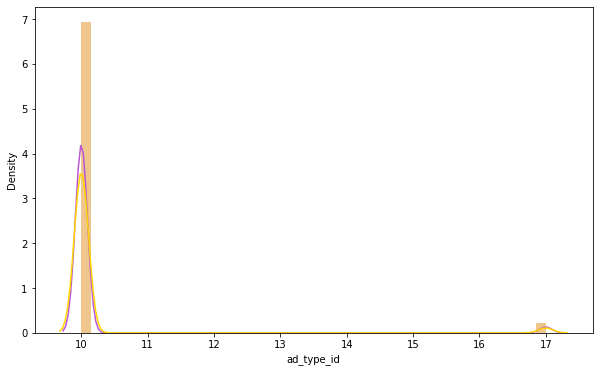

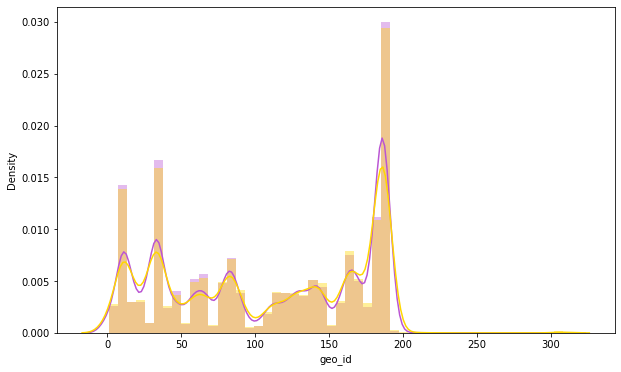

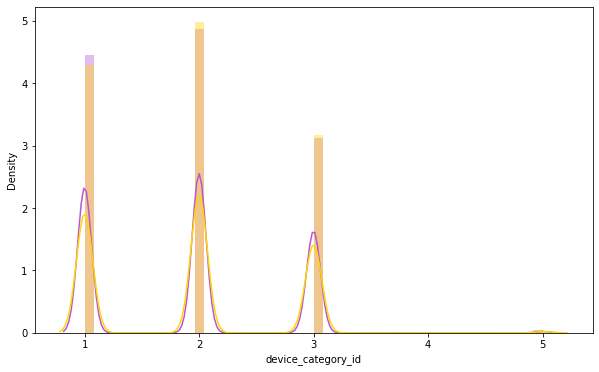

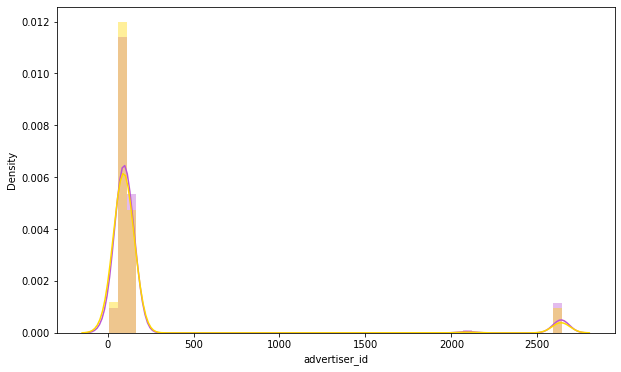

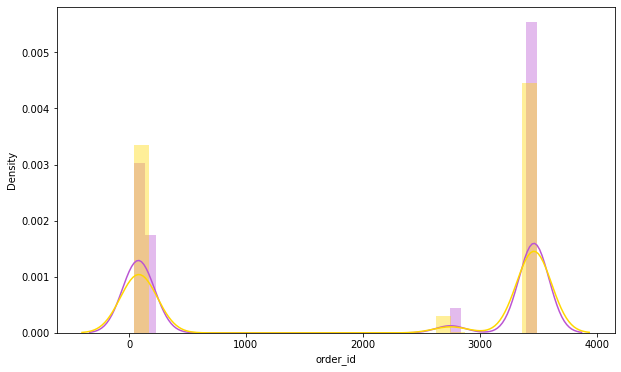

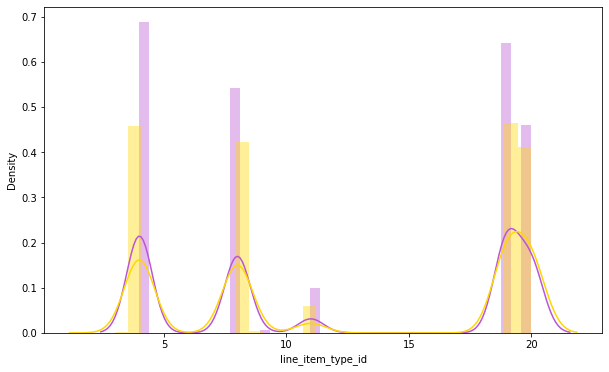

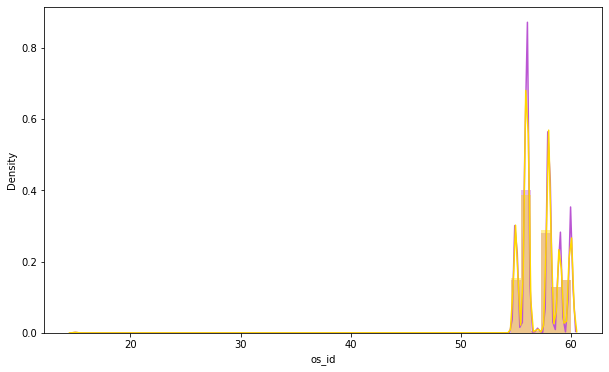

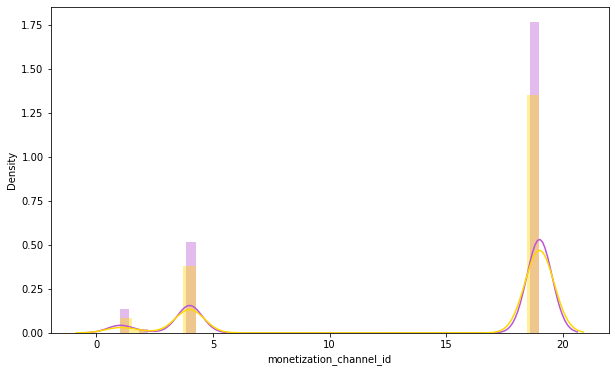

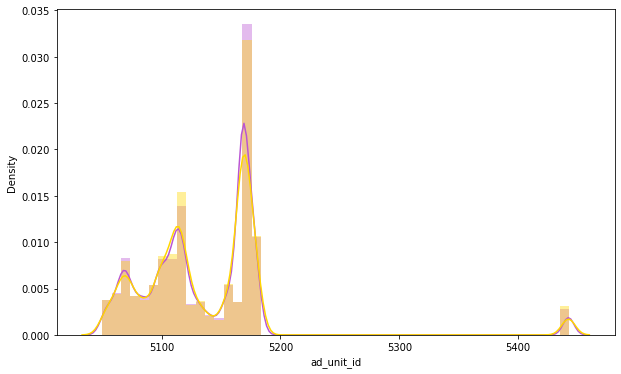

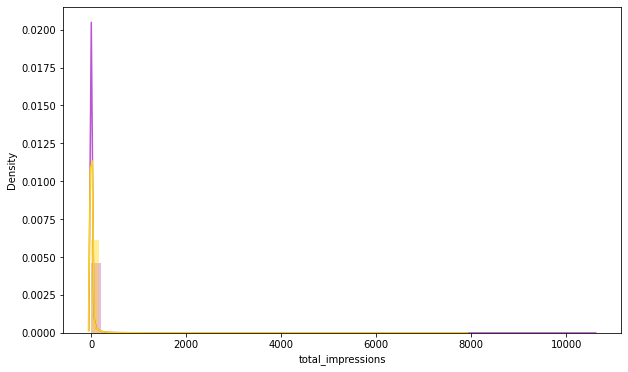

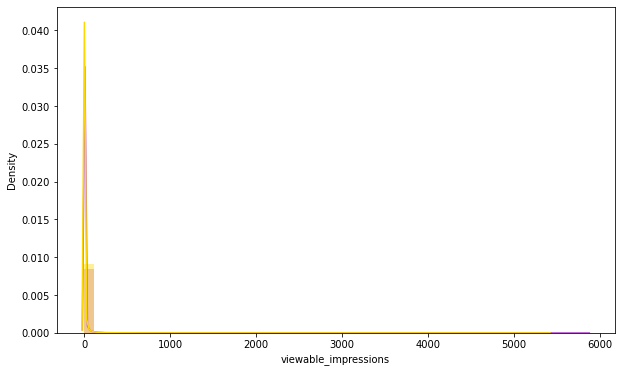

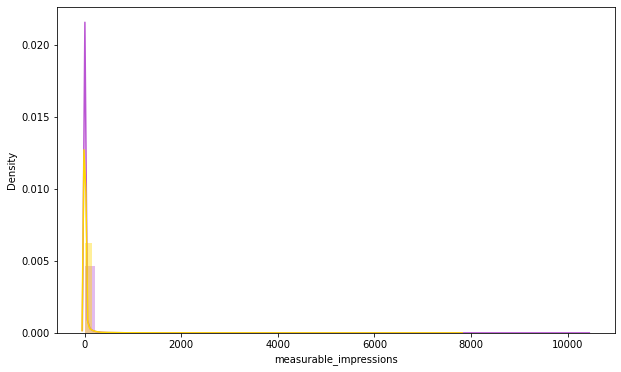

In [18]:
for f in tqdm(features):
    plt.figure(figsize = (10,6))
    sns.distplot(train_data[f], color = 'mediumorchid')
    sns.distplot(test_data[f], color = 'gold')

#### очень хвостато всё

### feature generation


в итоге позволяет лишь сильнее переобучиться под train - не используем, но для истории оставим

In [ ]:
# from itertools import combinations
# from copy import deepcopy

# train_data['weekday'] = pd.to_datetime(train_data['date']).dt.weekday
# test_data['weekday'] = pd.to_datetime(test_data['date']).dt.weekday

# cat_features += ['weekday']

# exclude_features = []

# CAT_UPPER_BOUND = 200

# for c in tqdm(cat_features):
#     if len(train_data[c].unique()) > CAT_UPPER_BOUND:
#         exclude_features.append(c)
#     train_data[c] = train_data[c].astype(str)
#     test_data[c] = test_data[c].astype(str)
    
# cross_cat_features = []
# for c1, c2 in tqdm(list(combinations(cat_features, 2))):
#     if c1 != c2:
#         c = f'{c1}_{c2}'
#         train_data[c] = train_data[c1].values + '_' + train_data[c2].values
#         test_data[c] = test_data[c1].values + '_' + test_data[c2].values
#         if len(train_data[c].unique()) > CAT_UPPER_BOUND:
#             exclude_features.append(c)
#         cross_cat_features.append(c)

In [ ]:
# from sklearn.preprocessing import LabelEncoder
# cat_encoders = {}
# new_cat_value = 'NAN'

# cat_features = [f for f in cat_features if f not in exclude_features] 
# cat_features_init = deepcopy(cat_features)
# cat_features += [f for f in cross_cat_features if f not in exclude_features] 

# for c in tqdm(cat_features):
#     encoder = LabelEncoder()
#     encoder.fit(train_data[c].fillna(new_cat_value))
#     le = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))
#     if new_cat_value not in le:
#         le[new_cat_value] = -1
#     cat_encoders[c] = le
#     train_data[c] = train_data[c].fillna(new_cat_value).apply(lambda x: x if x in le else new_cat_value).replace(le)
#     test_data[c] = test_data[c].fillna(new_cat_value).apply(lambda x: x if x in le else new_cat_value).replace(le)

# from sklearn.preprocessing import PolynomialFeatures
# pf = PolynomialFeatures(2)
# train_pf = pd.DataFrame(pf.fit_transform(train_data[num_features]))
# test_pf = pd.DataFrame(pf.transform(test_data[num_features]))
# poly_features = [f'pf_{i}' for i in range(train_pf.shape[1])]
# train_pf.columns = poly_features
# test_pf.columns = poly_features

# train_data = pd.concat([train_data, train_pf], axis = 1)
# test_data = pd.concat([test_data, test_pf], axis = 1)

In [ ]:
# with open(path_to_files + 'poly_features.pkl', 'wb') as f:
#     pickle.dump(poly_features, f)
# with open(path_to_files + 'cat_features_init.pkl', 'wb') as f:
#     pickle.dump(cat_features_init, f)
# with open(path_to_files + 'cat_features.pkl', 'wb') as f:
#     pickle.dump(cat_features, f)
# with open(path_to_files + 'cross_cat_features.pkl', 'wb') as f:
#     pickle.dump(cross_cat_features, f)
# with open(path_to_files + 'num_features.pkl', 'wb') as f:
#     pickle.dump(num_features, f)
# with open(path_to_files + 'cat_encoders.pkl', 'wb') as f:
#     pickle.dump(cat_encoders, f)

In [ ]:
# train_data.to_csv(path_to_files + 'train.csv', index = False)
# test_data.to_csv(path_to_files + 'test.csv', index = False)

### metrics & optimizations

In [19]:
from sklearn.metrics import make_scorer
import scipy.optimize

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def mean_absolute_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred)))

def mean_squared_error(y_true, y_pred): 
    return np.mean((y_true - y_pred) ** 2)

def get_importances(lgb):
    return pd.DataFrame({'feature':lgb.booster_.feature_name(), 'importance': lgb.booster_.feature_importance('gain'),}).sort_values(by = 'importance', ascending = False)

def calc_optimal_shift(y_true, y_predicted):

    start_point = (y_true - y_predicted).mean(axis = 0)
    def f(x):
        return mean_squared_error(y_true, y_predicted + x)
    res = scipy.optimize.minimize(f, start_point, method='nelder-mead', options={'xtol': 1e-4, 'disp': True})

    return res.x

def calc_optimal_alpha(y_true, y_predicted):

    alpha = 1
    def f(alpha):
        return mean_squared_error(y_true, alpha * y_predicted)
    res = scipy.optimize.minimize(f, alpha, method='nelder-mead', options={'xtol': 1e-4, 'disp': True})

    return res.x

mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better = False)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better = False)
mse_scorer = make_scorer(mean_squared_error, greater_is_better = False)

### grid settings

In [20]:
lgb_params = {'max_depth': 3, 'num_leaves': 16, 'n_estimators':800, 'min_child_samples':100}
lgb_grid = {'max_depth': np.arange(2, 10), 'num_leaves': 2**np.arange(3,10),
            'reg_alpha': 10.0**np.arange(-2, 3), 'reg_lambda': 10.0**np.arange(-2, 3), 'feature_fraction': np.arange(0.7, 1.1, 0.1),
            'n_estimators':np.linspace(50, 1000, 100, dtype = int), 'min_child_samples':np.linspace(50, 1000, 100, dtype = int)}

### direct mse optimization through stochastic grid search





In [22]:
X_train, y_train = train_data[features], train_data['CPM']
X_val, y_val = test_data[features], test_data['CPM']

# X_train, y_train = train_data[cat_features_init + num_features + poly_features], train_data['CPM']
# X_val, y_val = test_data[cat_features_init + num_features + poly_features], test_data['CPM']

In [23]:
%%time
lgb = LGBMRegressor(random_state = 8, metric = None, n_jobs = -1, objective = 'mse')
grid = RandomizedSearchCV(lgb, param_distributions = lgb_grid, cv = KFold(2, random_state = 8),
                          n_jobs= -1, refit = False,
                          n_iter = 10, scoring = mse_scorer, verbose = True, random_state = 8)
grid.fit(X_train, y_train,
         eval_metric = 'mse', early_stopping_rounds = 50, eval_set = (X_val, y_val),
         **{'categorical_feature': cat_features}
         )

grid.best_params_, grid.best_score_

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


CPU times: user 264 ms, sys: 128 ms, total: 392 ms
Wall time: 2min 1s


[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  2.0min finished


In [25]:
pprint(grid.best_params_)
lgb_best = lgb.set_params(**grid.best_params_)
lgb_best.set_params(**{'n_estimators': 5000,
                       'objective': 'mse'})

lgb_best.fit(X_train, y_train,
         eval_metric = 'mse', early_stopping_rounds = 50, eval_set = (X_val, y_val),
         **{'categorical_feature': cat_features}
         )

{'feature_fraction': 0.9999999999999999,
 'max_depth': 7,
 'min_child_samples': 798,
 'n_estimators': 529,
 'num_leaves': 16,
 'reg_alpha': 10.0,
 'reg_lambda': 0.1}


/usr/local/lib/python3.6/dist-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categorical_feature is ['ad_type_id', 'ad_unit_id', 'advertiser_id', 'device_category_id', 'geo_id', 'line_item_type_id', 'monetization_channel_id', 'order_id', 'os_id', 'site_id']
  'New categorical_feature is {}'.format(sorted(list(categorical_feature))))


[1]	valid_0's l2: 9402.11
Training until validation scores don't improve for 50 rounds.
[2]	valid_0's l2: 8265.25
[3]	valid_0's l2: 7328.92
[4]	valid_0's l2: 6586.78
[5]	valid_0's l2: 5962.25
[6]	valid_0's l2: 5472.35
[7]	valid_0's l2: 5076.91
[8]	valid_0's l2: 4727.54
[9]	valid_0's l2: 4451.94
[10]	valid_0's l2: 4209.16
[11]	valid_0's l2: 4021.82
[12]	valid_0's l2: 3864.69
[13]	valid_0's l2: 3733.15
[14]	valid_0's l2: 3613.44
[15]	valid_0's l2: 3510.99
[16]	valid_0's l2: 3426.92
[17]	valid_0's l2: 3366.83
[18]	valid_0's l2: 3311.15
[19]	valid_0's l2: 3260.26
[20]	valid_0's l2: 3222.5
[21]	valid_0's l2: 3183.97
[22]	valid_0's l2: 3152.7
[23]	valid_0's l2: 3125.15
[24]	valid_0's l2: 3099.13
[25]	valid_0's l2: 3074.48
[26]	valid_0's l2: 3054.21
[27]	valid_0's l2: 3036.15
[28]	valid_0's l2: 3020.67
[29]	valid_0's l2: 2999.06
[30]	valid_0's l2: 2981.58
[31]	valid_0's l2: 2967.52
[32]	valid_0's l2: 2958.21
[33]	valid_0's l2: 2945.25
[34]	valid_0's l2: 2929.1
[35]	valid_0's l2: 2918.55
[36]	

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              feature_fraction=0.9999999999999999, importance_type='split',
              learning_rate=0.1, max_depth=7, metric=None,
              min_child_samples=798, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=5000, n_jobs=-1, num_leaves=16, objective='mse',
              random_state=8, reg_alpha=10.0, reg_lambda=0.1, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

### посмотрим на базовые значимости

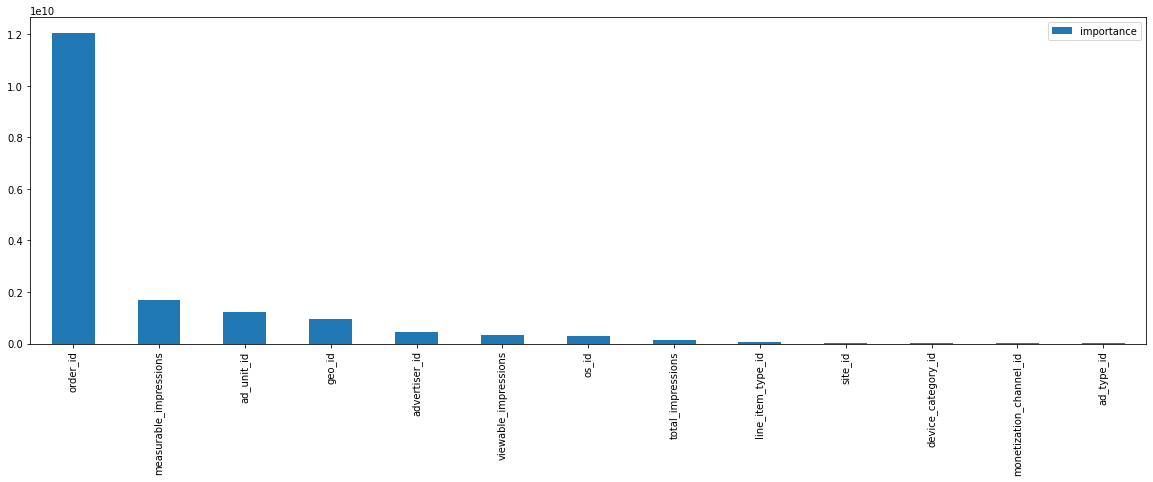

In [26]:
imps = get_importances(lgb_best)
fig, ax = plt.subplots(1,1,figsize = (20,6))
imps[['importance']].plot(kind = 'bar', ax = ax)
_ = ax.set_xticklabels(imps['feature'])

### scoring

In [27]:
y_train_pred = lgb_best.predict(X_train)
y_val_pred = lgb_best.predict(X_val)
mean_squared_error(y_train, y_train_pred), mean_squared_error(y_val, y_val_pred)

(2053.32784165012, 2625.955933082103)

### кажется, вполне неплохо

да, мы немного использовали тест выборку при отборе значений категориальных фичей и при early stopping, но не то, чтобы тюнились под нее сильно явно

это не best practice, но здесь-то задача стоит именно на ней оптимизировать mse, так что..

### посмотрим на распределения

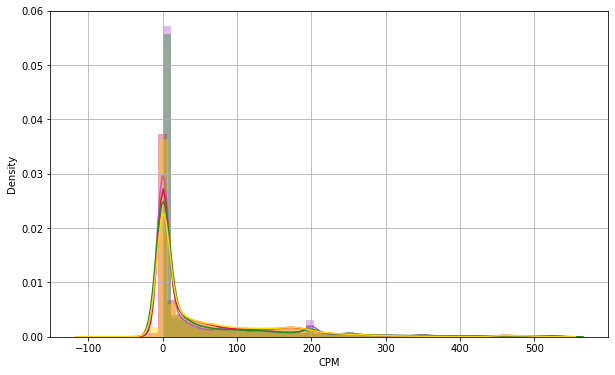

In [28]:
plt.figure(figsize = (10,6))

sns.distplot(y_train, color = 'mediumorchid')
sns.distplot(y_train_pred, color = 'crimson')
sns.distplot(y_val, color = 'forestgreen')
sns.distplot(y_val_pred, color = 'gold')
plt.grid(True)

### бустинг в регрессиях в силу своей природы построения иногда залезает в отрицательную область, даже если true target неотрицателен - подкорректируем


а раз уж решили оптимизироваться под test, то ещё и линейный сдвиг к прогнозу найдём

In [29]:
def clip_correction(y_predicted, low = 0, high = np.inf):
    return np.clip(y_predicted, low, high)

def calc_optimal_transformation(y_true, y_predicted):

    x = np.array([1,1])
    def f(x):
        return mean_squared_error(y_true, x[0] + x[1] * y_predicted)
    res = scipy.optimize.minimize(f, x, method='nelder-mead', options={'xtol': 1e-4, 'disp': True})

    return res.x

In [30]:
mean_squared_error(y_train, clip_correction(y_train_pred)), mean_squared_error(y_val, clip_correction(y_val_pred))

(2050.208862473428, 2620.8900460536197)

In [31]:
calc_optimal_transformation(y_train, clip_correction(y_train_pred)), calc_optimal_transformation(y_val, clip_correction(y_val_pred))

Optimization terminated successfully.
         Current function value: 2048.331219
         Iterations: 49
         Function evaluations: 93
Optimization terminated successfully.
         Current function value: 2611.798347
         Iterations: 49
         Function evaluations: 94


(array([-1.23699527,  1.01411862]), array([-1.74549421,  0.98462177]))

In [32]:
linear_correction_coefs = calc_optimal_transformation(y_val, clip_correction(y_val_pred))

Optimization terminated successfully.
         Current function value: 2611.798347
         Iterations: 49
         Function evaluations: 94


### сохраним модель

In [34]:
with open(path_to_files+'lgb_final_model.pkl', 'wb') as f:
    pickle.dump(lgb_best, f)

### ещё раз убедимся, что не использовали ничего лишнего

In [36]:
display(X_train.head())
display(X_val.head())

,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions
0,347,10,187,1,96,146,19,56,4,5122,2,0,2
1,347,10,68,1,96,146,19,56,4,5122,2,0,2
2,351,10,187,2,84,3473,19,58,4,5174,4,2,4
3,351,10,140,2,84,3473,19,58,4,5174,2,0,2
4,351,10,33,2,84,3473,19,60,4,5174,4,0,4


,site_id,ad_type_id,geo_id,device_category_id,advertiser_id,order_id,line_item_type_id,os_id,monetization_channel_id,ad_unit_id,total_impressions,viewable_impressions,measurable_impressions
0,351,10,187,2,84,3473,19,60,4,5174,16,2,16
1,351,10,187,2,84,3473,19,58,4,5174,6,0,6
2,351,10,147,2,84,3473,19,60,4,5174,4,0,4
3,351,10,147,2,84,3473,19,58,4,5174,4,0,4
4,348,10,147,3,79,3463,20,59,19,5138,4,0,4


### Finally,

In [37]:
final_forecast = linear_correction_coefs[0] + linear_correction_coefs[1] * clip_correction(y_val_pred)

In [38]:
f'Final MSE Value on Test :{mean_squared_error(y_val, final_forecast):.4f}'

'Final MSE Value on Test :2611.7983'